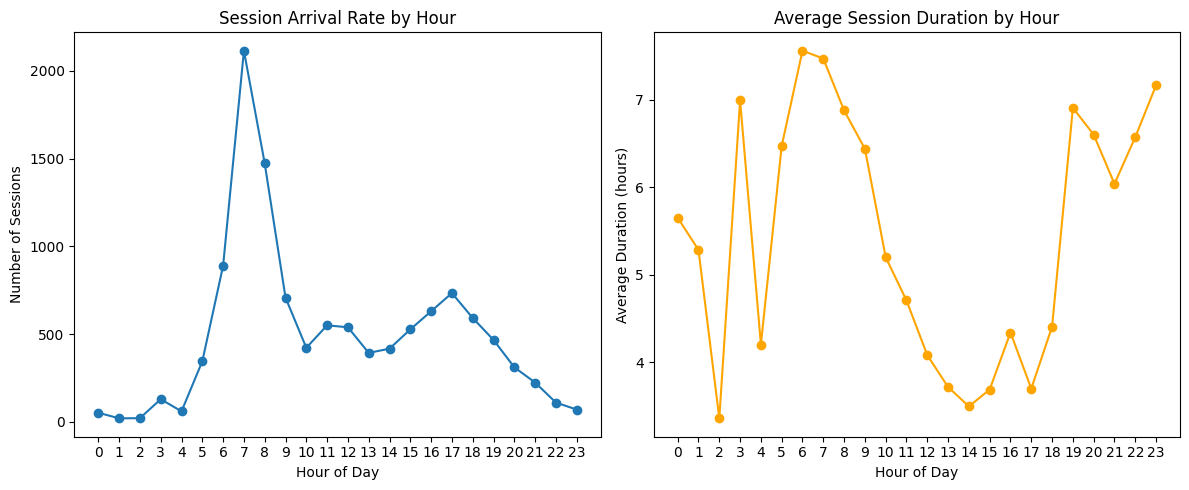

Arrival Rate by Hour:
hour
0       52
1       20
2       21
3      129
4       60
5      345
6      890
7     2115
8     1473
9      708
10     422
11     550
12     539
13     393
14     417
15     527
16     630
17     734
18     592
19     467
20     311
21     224
22     110
23      70
dtype: int64

Average Session Duration by Hour (in hours):
hour
0     5.650000
1     5.282917
2     3.359193
3     6.990418
4     4.201898
5     6.470010
6     7.557685
7     7.468058
8     6.875583
9     6.437886
10    5.199063
11    4.705216
12    4.080679
13    3.717125
14    3.495236
15    3.688063
16    4.339456
17    3.698330
18    4.406499
19    6.905693
20    6.598889
21    6.037323
22    6.571465
23    7.162329
Name: session_duration, dtype: float64


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime, timedelta

# =============================================================================
# 1. LOAD THE DATA
# =============================================================================
df = pd.read_csv('acndata_sessions.csv')

# =============================================================================
# 2. DATA CLEANING AND FILTERING
# =============================================================================
df.dropna(subset=['sessionID', 'connectionTime', 'disconnectTime'], inplace=True)

# Ensure connectionTime and disconnectTime are in datetime format.
df['connectionTime'] = pd.to_datetime(df['connectionTime'], errors='coerce')
df['disconnectTime'] = pd.to_datetime(df['disconnectTime'], errors='coerce')
df.dropna(subset=['connectionTime', 'disconnectTime'], inplace=True)

# Calculate session duration in hours.
df['session_duration'] = (df['disconnectTime'] - df['connectionTime']).dt.total_seconds() / 3600.0

# =============================================================================
# 3. PLOTTING ARRIVAL RATE AND AVERAGE SESSION DURATION BY HOUR
# =============================================================================

# Extract hour from connectionTime.
df['hour'] = (df['connectionTime'].dt.hour - 8) % 24

# Calculate the arrival rate: number of sessions per hour.
arrival_rate = df.groupby('hour').size()

# Calculate the average session duration per hour.
avg_duration = df.groupby('hour')['session_duration'].mean()

# Set up the figure and subplots.
plt.figure(figsize=(12, 5))

# Plot the arrival rate.
plt.subplot(1, 2, 1)
plt.plot(arrival_rate.index, arrival_rate.values, marker='o')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Sessions')
plt.title('Session Arrival Rate by Hour')
plt.xticks(range(0, 24))

# Plot the average session duration.
plt.subplot(1, 2, 2)
plt.plot(avg_duration.index, avg_duration.values, marker='o', color='orange')
plt.xlabel('Hour of Day')
plt.ylabel('Average Duration (hours)')
plt.title('Average Session Duration by Hour')
plt.xticks(range(0, 24))

plt.tight_layout()
plt.show()

# Optionally, print the computed metrics for verification.
print("Arrival Rate by Hour:")
print(arrival_rate.sort_index())
print("\nAverage Session Duration by Hour (in hours):")
print(avg_duration.sort_index())

In [5]:
# Print out the available columns for verification
print("Columns in CSV:", df.columns.tolist())

# Count and print the number of unique stations, spaces, and sites
if 'stationID' in df.columns:
    num_stations = df['stationID'].nunique()
    print("Number of unique stations:", num_stations)
else:
    print("Column 'stationID' not found in data.")

if 'spaceID' in df.columns:
    num_spaces = df['spaceID'].nunique()
    print("Number of unique spaces:", num_spaces)
else:
    print("Column 'space' not found in data.")

if 'siteID' in df.columns:
    num_sites = df['siteID'].nunique()
    print("Number of unique sites:", num_sites)
else:
    print("Column 'site' not found in data.")

Columns in CSV: ['_id', 'clusterID', 'connectionTime', 'disconnectTime', 'doneChargingTime', 'kWhDelivered', 'sessionID', 'siteID', 'spaceID', 'stationID', 'timezone', 'userID', 'userInputs', 'session_duration', 'hour']
Number of unique stations: 54
Number of unique spaces: 54
Number of unique sites: 1


ModuleNotFoundError: No module named 'plotly'

In [7]:
!pip install plotly

   ---------------------------------------- 0.0/14.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.8 MB ? eta -:--:--
    --------------------------------------- 0.3/14.8 MB ? eta -:--:--
   - -------------------------------------- 0.5/14.8 MB 1.1 MB/s eta 0:00:13
   -- ------------------------------------- 0.8/14.8 MB 1.3 MB/s eta 0:00:11
   --- ------------------------------------ 1.3/14.8 MB 1.6 MB/s eta 0:00:09
   ---- ----------------------------------- 1.6/14.8 MB 1.6 MB/s eta 0:00:09
   ----- ---------------------------------- 2.1/14.8 MB 1.7 MB/s eta 0:00:08
   --------- ------------------------------ 3.4/14.8 MB 2.3 MB/s eta 0:00:05
   ------------ --------------------------- 4.5/14.8 MB 2.7 MB/s eta 0:00:04
   --------------- ------------------------ 5.8/14.8 MB 3.1 MB/s eta 0:00:03
   ------------------- -------------------- 7.1/14.8 MB 3.5 MB/s eta 0:00:03
   -------------------- ------------------- 7.6/14.8 MB 3.5 MB/s eta 0:00:03
   -----------------

In [9]:
import plotly.express as px

station_counts = df['stationID'].value_counts().reset_index()
station_counts.columns = ['stationID', 'Usage']

space_counts = df['spaceID'].value_counts().reset_index()
space_counts.columns = ['spaceID', 'Usage']

site_counts = df['siteID'].value_counts().reset_index()
site_counts.columns = ['siteID', 'Usage']

# Create an interactive bar chart for station usage
fig_station = px.bar(
    station_counts,
    x='stationID',
    y='Usage',
    title='Usage by Station',
    labels={'stationID': 'Station ID', 'Usage': 'Number of Sessions'}
)
fig_station.show()

# Create an interactive bar chart for space usage
fig_space = px.bar(
    space_counts,
    x='spaceID',
    y='Usage',
    title='Usage by Space',
    labels={'space': 'Space', 'Usage': 'Number of Sessions'}
)
fig_space.show()

# Create an interactive bar chart for site usage
fig_site = px.bar(
    site_counts,
    x='siteID',
    y='Usage',
    title='Usage by Site',
    labels={'site': 'Site', 'Usage': 'Number of Sessions'}
)
fig_site.show()